<a href="https://colab.research.google.com/github/ameyaoka/-makemore-/blob/main/makemore_MPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A neural probabilistic language model



### mlp - multilayer perceptron

In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot
%matplotlib inline

### Download data

In [51]:
! wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-06-20 06:34:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-06-20 06:34:10 (13.0 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [52]:
words =  open('names.txt','r').read().splitlines()

In [53]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [54]:
len(words) # total vocabulary

32033

1.  The set() function is used to remove duplicate characters, ensuring each character appears only once.
  - list() is then used to convert the set back into a list.'
  - sorted() is applied to sort the characters in alphabetical order.
2.  stoi : we create a maping from chars in char list to integers.
  - enumerate iterates over elements in char  and return (index , element) pair .
  - i represents position of element in chars and s represents element itself.
  - we create a dictionary of key ,val pair where char is key and mapped to index i+1 ( 0 is reserved for special char start and end )

3. itos is dictionary similar to stoi but reversed number to pair .
  - stoi.items() returns a view object that represents the key-value pairs from the stoi dictionary.


In [55]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build the dataset

1. block_size is how many chars to serve as input for prediction .
2. initialize empty list of input and output .
3. loop for iterating over words
4. print (w) prints whole word.
5. create a new list with name context . initialize thi list with block_size no of zeros (3)
6. use for loop to iterate over each character in word (w) and '.'  as end of word token.
7.  using stoi defined earlier convert word to its corresponding index. store index in var ix.
8. append the current context into X ( we use context bec we want input as 3 char .first context will always be 000 .
9. append index ix into Y .( labels )
10. print chars from index i in context which is 0 for first iteratin. then print ---> and print char with index ix which is label.
11. Now we have to update context next input should be [ ..e] ie [0,0,ix] .
12.convert list X into pytorch tensor.
13. convert list of Y into pytorch tensor.


In [56]:

block_size = 3  # how many chars serve as input for prediction of next word
X ,Y =[],[]         # Initialize empty lists for input-output pairs.

for w in words[:5]: # iterate over words (first 5)

  print(w)              # print word
  context = [0]*block_size      # initialize list with name context .
                                # This means that initially, the context list
                                # is filled with block_size number of zeros
                                # block_size =3 , context = [0,0,0]
  for ch in w + '.':        #Iterate over each character in the current word,
    ix= stoi[ch]            # convert the character to its corresponding index
    X.append(context)        # Append the current context to the input list "X
    Y.append(ix)              # append current index to output list Y
    print(''.join(itos[i] for i in context), '--->', itos[ix])# Append the current context to the input list "X
    context = context[1:] + [ix]    # Update the context by removing the first element and adding the current index

X = torch.tensor(X)  # Convert the input list "X" to a PyTorch tensor
Y = torch.tensor(Y)  # Convert the output list "Y" to a PyTorch tensor

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [57]:
X.shape , X.dtype , Y.shape , Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [58]:
X # training examples

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [59]:
Y # labels

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

- creates a tensor with dimensions (27, 2) and fills it with random numbers sampled from a standard normal distribution (mean 0, standard deviation 1).

In [60]:
C = torch.randn((27,2))

In [61]:
C

tensor([[ 0.2271, -0.2526],
        [-1.1527,  0.2431],
        [ 0.9183, -1.2229],
        [ 1.2986,  1.4891],
        [-0.4131, -0.9154],
        [ 0.6295, -0.3166],
        [-0.8579,  0.6571],
        [-0.6229, -0.2423],
        [ 1.6893,  1.3305],
        [-1.1558,  0.7241],
        [ 1.6289, -0.9787],
        [-0.7048, -1.5517],
        [-1.0420, -1.3753],
        [-2.1787,  0.2408],
        [-0.3141, -0.3727],
        [ 0.7925, -1.7941],
        [ 0.3572,  0.6294],
        [-1.5124, -0.8216],
        [-0.9228, -0.6910],
        [ 0.0820, -0.5848],
        [ 0.5732, -0.0344],
        [ 0.1625, -1.9283],
        [ 2.0339, -0.9479],
        [-0.2381,  0.3572],
        [-0.6940, -1.5599],
        [ 0.6365,  0.4327],
        [-0.9962, -0.8200]])

In [62]:
F.one_hot(torch.tensor(5),num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [63]:
# Take one hot vect and mulitply by C
# one_hot encoding by default is int . so need to convert to float.
F.one_hot(torch.tensor(5),num_classes=27).float() @ C


tensor([ 0.6295, -0.3166])

In [64]:
C[5]

tensor([ 0.6295, -0.3166])

- both output of above lines are same  .

- Pytorch indexing -- learn

In [65]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [66]:
emb

tensor([[[ 0.2271, -0.2526],
         [ 0.2271, -0.2526],
         [ 0.2271, -0.2526]],

        [[ 0.2271, -0.2526],
         [ 0.2271, -0.2526],
         [ 0.6295, -0.3166]],

        [[ 0.2271, -0.2526],
         [ 0.6295, -0.3166],
         [-2.1787,  0.2408]],

        [[ 0.6295, -0.3166],
         [-2.1787,  0.2408],
         [-2.1787,  0.2408]],

        [[-2.1787,  0.2408],
         [-2.1787,  0.2408],
         [-1.1527,  0.2431]],

        [[ 0.2271, -0.2526],
         [ 0.2271, -0.2526],
         [ 0.2271, -0.2526]],

        [[ 0.2271, -0.2526],
         [ 0.2271, -0.2526],
         [ 0.7925, -1.7941]],

        [[ 0.2271, -0.2526],
         [ 0.7925, -1.7941],
         [-1.0420, -1.3753]],

        [[ 0.7925, -1.7941],
         [-1.0420, -1.3753],
         [-1.1558,  0.7241]],

        [[-1.0420, -1.3753],
         [-1.1558,  0.7241],
         [ 2.0339, -0.9479]],

        [[-1.1558,  0.7241],
         [ 2.0339, -0.9479],
         [-1.1558,  0.7241]],

        [[ 2.0339, -0

In [67]:
# weights
W1 = torch.randn((6,100))
# bias
b1 = torch.randn(100)

- Normally emb @ w1 + b1
- but cant multiply (32,3,2) and (6,100)
- emb[:,0,:]

- but below code is not generalized
so cant pass dim which we want.


In [68]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1)

tensor([[ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.6295, -0.3166],
        [ 0.2271, -0.2526,  0.6295, -0.3166, -2.1787,  0.2408],
        [ 0.6295, -0.3166, -2.1787,  0.2408, -2.1787,  0.2408],
        [-2.1787,  0.2408, -2.1787,  0.2408, -1.1527,  0.2431],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.7925, -1.7941],
        [ 0.2271, -0.2526,  0.7925, -1.7941, -1.0420, -1.3753],
        [ 0.7925, -1.7941, -1.0420, -1.3753, -1.1558,  0.7241],
        [-1.0420, -1.3753, -1.1558,  0.7241,  2.0339, -0.9479],
        [-1.1558,  0.7241,  2.0339, -0.9479, -1.1558,  0.7241],
        [ 2.0339, -0.9479, -1.1558,  0.7241, -1.1527,  0.2431],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526, -1.1527,  0.2431],
        [ 0.2271, -0.2526, -1.1527,  0.2431,  2.0339, -0.9479],
        [-1.1527,  0.2431,  2.0339, -0.9

- **generalization of above code**

In [69]:
torch.cat(torch.unbind(emb,1),1)

tensor([[ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.6295, -0.3166],
        [ 0.2271, -0.2526,  0.6295, -0.3166, -2.1787,  0.2408],
        [ 0.6295, -0.3166, -2.1787,  0.2408, -2.1787,  0.2408],
        [-2.1787,  0.2408, -2.1787,  0.2408, -1.1527,  0.2431],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.7925, -1.7941],
        [ 0.2271, -0.2526,  0.7925, -1.7941, -1.0420, -1.3753],
        [ 0.7925, -1.7941, -1.0420, -1.3753, -1.1558,  0.7241],
        [-1.0420, -1.3753, -1.1558,  0.7241,  2.0339, -0.9479],
        [-1.1558,  0.7241,  2.0339, -0.9479, -1.1558,  0.7241],
        [ 2.0339, -0.9479, -1.1558,  0.7241, -1.1527,  0.2431],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526, -1.1527,  0.2431],
        [ 0.2271, -0.2526, -1.1527,  0.2431,  2.0339, -0.9479],
        [-1.1527,  0.2431,  2.0339, -0.9

In [70]:
a = torch.arange(18)

In [71]:
a.shape

torch.Size([18])

In [72]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [73]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

- storage remains same but seen as different
-Blog below goes in depth
- http://blog.ezyang.com/2019/05/pytorch-internals/

**Imp**
- **In storage A tensor is always representated as one dim vector.**
- **when we call view some internal attributes of view of tensor changes .**
-**NO new memory is created or copied The storage is identical internal view is changed ( storge offset ,strid ,shapes).**
- **Torch.cat creates now memory etc so not effecient as .view**

In [74]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

- more effecient way .

In [75]:
emb.shape

torch.Size([32, 3, 2])

In [76]:
emb.view(32,6)

tensor([[ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.6295, -0.3166],
        [ 0.2271, -0.2526,  0.6295, -0.3166, -2.1787,  0.2408],
        [ 0.6295, -0.3166, -2.1787,  0.2408, -2.1787,  0.2408],
        [-2.1787,  0.2408, -2.1787,  0.2408, -1.1527,  0.2431],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.7925, -1.7941],
        [ 0.2271, -0.2526,  0.7925, -1.7941, -1.0420, -1.3753],
        [ 0.7925, -1.7941, -1.0420, -1.3753, -1.1558,  0.7241],
        [-1.0420, -1.3753, -1.1558,  0.7241,  2.0339, -0.9479],
        [-1.1558,  0.7241,  2.0339, -0.9479, -1.1558,  0.7241],
        [ 2.0339, -0.9479, -1.1558,  0.7241, -1.1527,  0.2431],
        [ 0.2271, -0.2526,  0.2271, -0.2526,  0.2271, -0.2526],
        [ 0.2271, -0.2526,  0.2271, -0.2526, -1.1527,  0.2431],
        [ 0.2271, -0.2526, -1.1527,  0.2431,  2.0339, -0.9479],
        [-1.1527,  0.2431,  2.0339, -0.9

In [77]:
emb.view(32,6) == torch.cat(torch.unbind(emb,1),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

- **Applying tanh function**

In [78]:
h= torch.tan(emb.view(-1,6) @ W1 + b1)

In [79]:
h

tensor([[ 1.1112,  0.2251, -4.9200,  ...,  0.2447, -1.7422, -0.1476],
        [ 0.4610,  0.3467, -8.6866,  ...,  0.2456, -1.5506,  0.6131],
        [ 0.6447, -0.0454, -0.0698,  ...,  0.3139, -2.2196, -3.6878],
        ...,
        [-1.2876,  1.9012, -0.1293,  ...,  0.4188,  3.0316,  1.0035],
        [ 0.3100, -6.6332,  0.1267,  ...,  1.1571, -0.1379,  1.2167],
        [-0.4990,  1.3169, -1.9888,  ..., -0.0236, -0.0544, -2.0584]])

- inputs are 100
- outputs are 27 ( possible category)
- bias are 27

In [80]:
W2 = torch.randn((100,27))

b2 = torch.randn(27)

- logits = output of the neural net.

In [81]:
logits = h @ W2 +b2

In [82]:
logits.shape

torch.Size([32, 27])

In [83]:
counts = logits.exp()

In [84]:
# normalised
prob = counts / counts.sum(1,keepdims=True)

**Negative log loss**

In [85]:
loss = -prob[torch.arange(32),Y].log().mean()

In [86]:
F.cross_entropy(logits,Y)

tensor(532.8934)

- we use F.cross entrophy because we we use formula we need to create new tensor in memory and backward pass is more effectien .
- f.cross is numerically well behaved .
- It internally normalize logits.

### Full neural network  neural net

- Dataset
- X - input is (32,3)(3 words )
- Y -  labels (32)(expected word)



In [87]:
X.shape , Y.shape

(torch.Size([32, 3]), torch.Size([32]))

1. g - This will ensure that the random numbers generated by the torch.randn functions are reproducible.
2. This line creates a tensor C of shape (27, 10) and fills it with random numbers from a normal distribution with mean 0 and variance 1.

3. w1,w2,b1,b2, weights and biases.

4. parameters : This line creates a list parameters containing the tensors C, W1, b1, W2, and b2. This list will be used to train the neural network.

In [118]:


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]



In [119]:
for p in parameters:
  p.requires_grad = True


-  the sum function to calculate the total number of parameters in the list parameters

- nelement() function is used to count the number of elements in a tensor.

In [90]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

- loof itertates over 1000 times.
- emb is input data X passed  through embedding layer C .
-

- h is the hidden laeyer . we apply hyperbolic tangent activtion to matrix multiplication of input emb with w1 and bias

-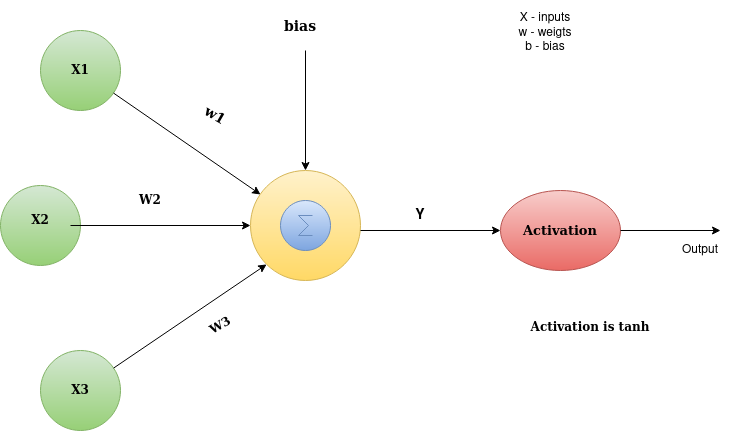


In [91]:
# fordward pass
for _ in range(1000):
  emb = C[X]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1 )
  logits = h @ W2 +b2
  loss = F.cross_entropy(logits ,Y)
# backward pass
  for  p in parameters:
    p.grad = None
  loss.backward()

# update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

0.2561509907245636


- we are using lots of neurons but less examples so we are overfitting.



- now lets take all examples.

In [92]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

In [93]:
for p in parameters:
  p.require_grad = True

In [94]:
for _ in range(10):


  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  for p in parameters:
    p.data += -0.1 * p.grad



0.2561323344707489
0.25613996386528015
0.2561213970184326
0.2561289668083191
0.2561105191707611
0.2561180293560028
0.2560997009277344
0.2561071515083313
0.25608891248703003
0.25609633326530457


### training split , dev/validation split , test split
### 80% ,  10% , 10%

- training split is used for training your neuralnet .
- dev / val split is for hyperparameter try different hyperparameter and check which works best .
- eval performance of your model .
(use test split less no of times to avoid overfitting testsplit.


- code for dataet generation is similar to above code .
- we want to split the dataset into 3 splits .(training , test , split.)
- we import random which provides us function to generate random numbers  and shuffling sequences.
- random.seed sets is used for reproducibility by generating same random numbers each time .
- n1 = int( 0.8 * len(words)) - we calculate index upto which training dataset extends 80% of length of data. same with n2 .
-  Using build dataset we build dataset and pass word[:n1] for selecting words from index 0 to n1 .
-  Using build dataset we build dataset and pass word[:n1] for selecting words from index 0 to n1 . xtr represents input-training , ytr represents label for training examples from xtr.


In [95]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


- Creates a one-dimensional tensor of size steps whose values are evenly spaced from start to end, inclusive.
- This is a list of learning rate .
- we change learning rate over iteration.


In [108]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [125]:
lri = []
lossi = []

for i in range(1000):

# mini batch .
  ix = torch.randint(0,X.shape[0], (32,))
# fordward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1 )
  logits = h @ W2 +b2
  loss = F.cross_entropy(logits ,Ytr[ix])
  print(loss.item())
# backward pass
  for  p in parameters:
    p.grad = None
  loss.backward()

# update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

17.043758392333984
16.658336639404297
13.963586807250977
17.578872680664062
15.714320182800293
16.245519638061523
16.267417907714844
16.51902198791504
15.51821517944336
16.46946907043457
16.72240447998047
17.57688331604004
14.039510726928711
16.342201232910156
14.588495254516602
17.1998233795166
15.073675155639648
14.188553810119629
13.780924797058105
16.0496883392334
13.51556396484375
16.661508560180664
14.083731651306152
15.8032808303833
16.714611053466797
13.33919906616211
16.46307373046875
14.45911979675293
16.493192672729492
15.617399215698242
17.488100051879883
16.7186279296875
14.059288024902344
13.818853378295898
16.132366180419922
16.75174903869629
13.98834228515625
16.20062828063965
16.983373641967773
14.207257270812988
15.560197830200195
13.075199127197266
14.699819564819336
14.814355850219727
16.953683853149414
12.903745651245117
14.145373344421387
15.068559646606445
14.64299201965332
13.44490909576416
14.255614280700684
14.870838165283203
13.676072120666504
15.359203338623

In [126]:
from matplotlib import pyplot as plt

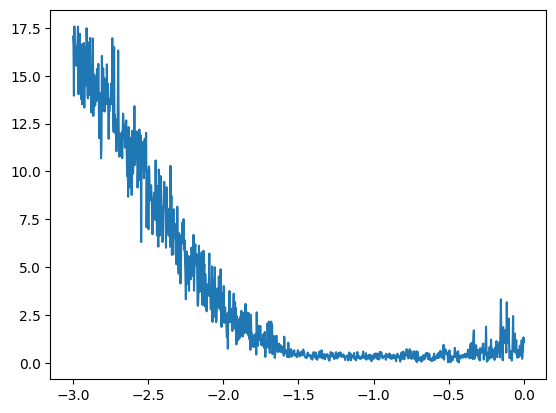

In [127]:
plt.plot(lri,lossi)

In [98]:
torch.randint(0, X.shape[0],(32,))

tensor([30, 16,  0,  7, 27,  9, 27, 30, 27, 21,  5, 29, 21, 16,  2,  8, 22, 27,
        30,  5,  6, 26, 23,  6, 21,  5,  4,  4,  0, 30,  9, 17])